# HW2P2: Image Recognition and Verification

# How to Run my Code

Just put my notebook in PSC environment and click **Run ALL**.

## Architecture details:
- Using a **ResNet-34** Network
- Trained for **50 Epochs**
- Using **AdadW** as Optimizer

### Config:
- **batch_size**: 64
- **lr**: 0.001
- **epochs**: 50
- **num_classes**: 8631
- **criterion**: CrossEntropyLoss (label_smoothing=0.2)

### Tried:
- **SEResnet** (but failed)
- **Triplet Loss** and **Arcface loss** to finetune the model (but failed)

## DataLoading Scheme:
Using Augmentation Skills:
- `T.RandomHorizontalFlip(p=0.5)`  # Randomly flip horizontally with 50% probability
- `T.RandomRotation(degrees=(-10, 10))`  # Randomly rotate within -10 to 10 degrees
- `T.RandomPerspective(distortion_scale=0.2, p=0.5)`  # Apply random perspective transformation
- `T.RandomResizedCrop(size=(112, 112), scale=(0.8, 1.0))`  # Randomly crop and resize
- `T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`  # Adjust color properties

Besides that, I just followed the standard data loading schemes provided in the notebook.

## Wandb Link:
[Wandb Experiment Link](https://wandb.ai/xlin5-carnegie-mellon-university/hw2p2?nw=nwuserhangruancmu) (marked as **yiboy-runs** in our group project)

Total **51** **yiboy** experiments recorded in Wandb, best Hyper-parameters and models presented as above.



![Alt text](image-2.png)


This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

zsh:1: command not found: nvidia-smi


In [2]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


TODO: Change Imports based on new dataset

In [3]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


ImportError: dlopen(/Users/yinyibo/opt/anaconda3/lib/python3.9/site-packages/torch/_C.cpython-39-darwin.so, 2): Library not loaded: @loader_path/libtorch_cpu.dylib
  Referenced from: /Users/yinyibo/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_python.dylib
  Reason: image not found

In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"yiboy123","key":"67b7feb997db1963bf81caf8b1b4e9ab"}')

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=412b587fcb7bee1a0412156845c7a40165fd3a28995445c63a47ab2d45367b89
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
#!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-spring-2025
!unzip -qo '11785-hw-2-p-2-face-verification-spring-2025' -d '/content/data'

100% 2.58G/2.59G [00:23<00:00, 97.0MB/s]
100% 2.59G/2.59G [00:23<00:00, 120MB/s] 


# Config

In [ ]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.001,
    'epochs': 20, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': "/content/data/HW2p2_S25/cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': "/content/data/HW2p2_S25/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "/content/data/HW2p2_S25/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "/content/data/HW2p2_S25/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "/content/drive/MyDrive/Checkpoints/HW2P2", #TODO: Checkpoint directory
    'augument': True
    # Include other parameters as needed.
}

# Dataset

In [ ]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
        transform_list.extend([
          T.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally with 50% probability
          T.RandomRotation(degrees=(-10, 10)), # Randomly rotate within -10 to 10 degrees
          T.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply random perspective transformation
          T.RandomResizedCrop(size=(112, 112), scale=(0.8, 1.0)),  # Randomly crop and resize
          T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1) # Adjust color properties
          #T.RandomVerticalFlip(p=0.5),
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

263

In [ ]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=True)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
#print(os.path.join(config['cls_data_dir'],"train"))
config['cls_data_dir']

'/content/data/HW2p2_S25/cls_data'

In [ ]:
# Datasets
cls_train_dataset = ImageDataset(os.path.join(config['cls_data_dir'],"train"), train_transforms)
cls_val_dataset   = ImageDataset(os.path.join(config['cls_data_dir'],"dev"), val_transforms)
cls_test_dataset  = ImageDataset(os.path.join(config['cls_data_dir'],"test"), val_transforms, num_classes=None)

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 43155/43155 [00:00<00:00, 148745.67it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Verification Dataset and Datatloaders

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [ ]:
# Datasets
ver_val_dataset  = ImagePairDataset(config['ver_data_dir'], config['val_pairs_file'], val_transforms)
ver_test_dataset = TestImagePairDataset(config['ver_data_dir'], config['test_pairs_file'], val_transforms)

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs: 100%|██████████| 6000/6000 [00:08<00:00, 728.30it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Create Dataloaders for Image Recognition

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  64
Train batches        :  6743
Val batches          :  675


###Classification Dataset Viz

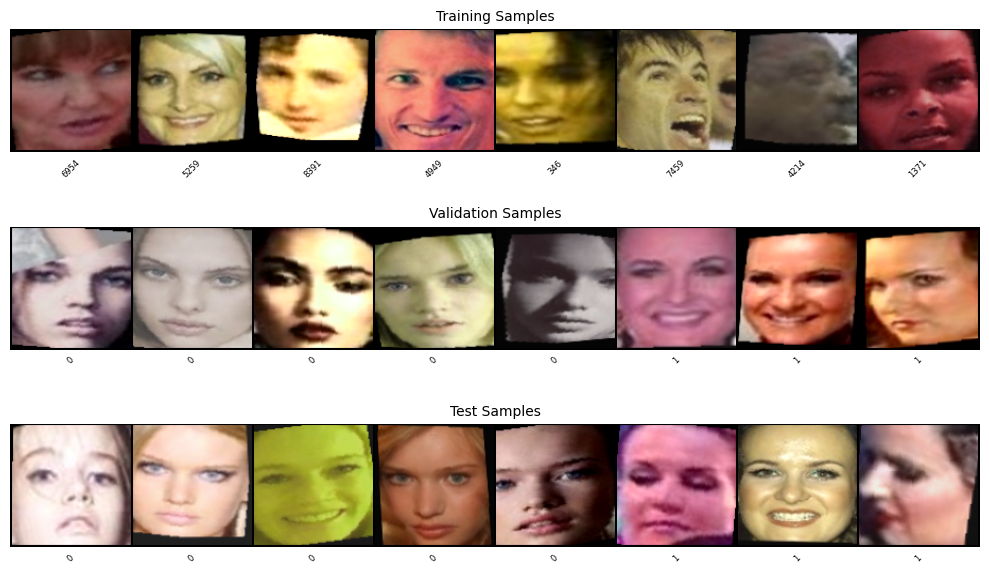

In [ ]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

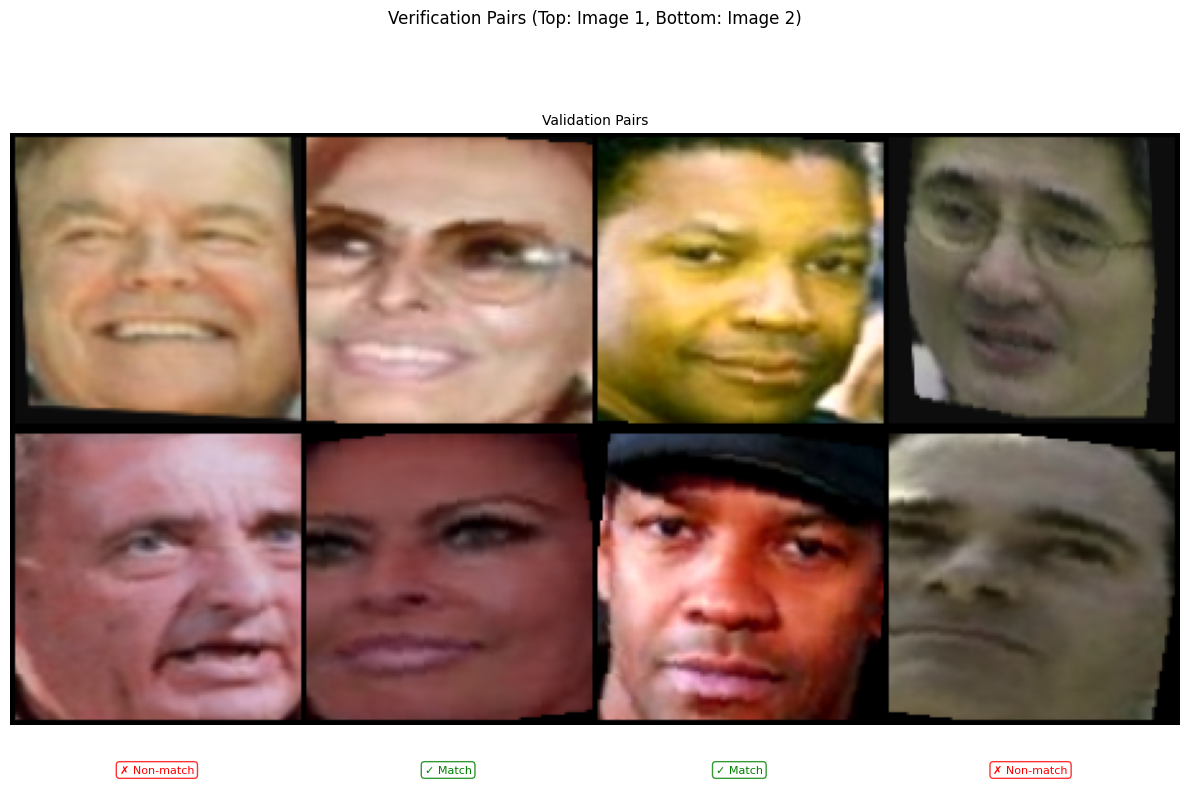

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # TODO: Fill out the model definition below

# class Network(torch.nn.Module):

#     def __init__(self, num_classes):
#         super().__init__()

#         self.backbone = torch.nn.Sequential(
#             # Conv1
#             torch.nn.Conv2d(3, 128, kernel_size=7, stride=4, padding = 3),
#             torch.nn.BatchNorm2d(128),
#             torch.nn.ReLU(),
#             # Conv2
#             torch.nn.Conv2d(128, 256, kernel_size=3, stride=2 , padding = 1),
#             torch.nn.BatchNorm2d(256),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(256, 256, kernel_size=3, stride=1 , padding = 1),
#             torch.nn.BatchNorm2d(256),
#             torch.nn.ReLU(),
#             # Conv3
#             torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding = 1),
#             torch.nn.BatchNorm2d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding = 1),
#             torch.nn.BatchNorm2d(512),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding = 1),
#             torch.nn.BatchNorm2d(512),
#             torch.nn.ReLU(),
#             # Conv4
#             torch.nn.Conv2d(512,1024, kernel_size=3, stride=2, padding=1),
#             torch.nn.BatchNorm2d(1024),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(1024,1024, kernel_size=3, stride=1, padding=1),
#             torch.nn.BatchNorm2d(1024),
#             torch.nn.ReLU(),
#             # Conv5
#             # Pooling
#             torch.nn.AdaptiveAvgPool2d((1, 1)),
#             torch.nn.Flatten()

#             )

#         self.cls_layer = torch.nn.Linear(1024, num_classes)

#     def forward(self, x):

#         feats = self.backbone(x)
#         out = self.cls_layer(feats)

#         return {"feats": feats, "out": out}

# # Initialize your model
# model = Network(num_classes=config['num_classes']).to(DEVICE)
# summary(model, (3, 112, 112))

In [ ]:
# import torch
# import torch.nn as nn
# from torchsummary import summary

# class SEModule(nn.Module):
#     def __init__(self, channels, reduction=16):
#         super(SEModule, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         module_input = x
#         x = self.avg_pool(x)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return module_input * x

# class Bottleneck(nn.Module):
#     expansion = 2.75  # 从 3.5 降低到 2.75

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, int(planes * self.expansion), kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(int(planes * self.expansion))
#         self.relu = nn.ReLU(inplace=True)
#         self.downsample = downsample
#         self.stride = stride
#         self.se = SEModule(int(planes * self.expansion))

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)
#         out = self.se(out)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         out += residual
#         out = self.relu(out)

#         return out

# class SEResNet(nn.Module):
#     def __init__(self, block, layers, num_classes=1000):
#         self.inplanes = 64  # 64 适中
#         super(SEResNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(int(512 * block.expansion), num_classes)  # 控制参数量

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != int(planes * block.expansion):
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, int(planes * block.expansion), kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(int(planes * block.expansion)),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = int(planes * block.expansion)
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         feats = x.view(x.size(0), -1)
#         out = self.fc(feats)

#         return {"feats": feats, "out": out}

# def se_resnet50(num_classes=1000):
#     return SEResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)  # 适中层数

# # 计算参数量
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = se_resnet50(num_classes=1000).to(DEVICE)
# summary(model, (3, 112, 112))


In [ ]:
# # # TODO: Fill out the model definition below

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision.models as models


class Network(nn.Module):
    """Residual Block with two 3x3 convolutions."""
    expansion = 1  # No expansion in ResNet-34

    def __init__(self, in_channels, out_channels, stride=1):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)


class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()

        self.in_channels = 64

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet-34 consists of 3, 4, 6, and 3 blocks in each stage
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc = nn.Linear(512 * Network.expansion, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        """Creates a residual layer with `num_blocks` residual blocks."""
        layers = []
        layers.append(Network(self.in_channels, out_channels, stride))
        self.in_channels = out_channels  # Update input channels for next blocks
        for _ in range(num_blocks - 1):
            layers.append(Network(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        feats = torch.flatten(x, start_dim=1)  # Flatten feature embeddings
        out = self.fc(feats)

        return {"feats": feats, "out": out}



# Initialize model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = Network(num_classes=config['num_classes']).to(DEVICE)

model = ResNet34(num_classes=config['num_classes']).to(DEVICE)

# Print model summary
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
            Conv2d-7           [-1, 64, 28, 28]          36,864
       BatchNorm2d-8           [-1, 64, 28, 28]             128
           Network-9           [-1, 64, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]          36,864
      BatchNorm2d-11           [-1, 64, 28, 28]             128
           Conv2d-12           [-1, 64, 28, 28]          36,864
      BatchNorm2d-13           [-1, 64, 28, 28]             128
          Network-14           [-1, 64,

In [ ]:
# # encoding:utf-8
# # Modify from torchvision
# # ResNeXt: Copy from https://github.com/last-one/tools/blob/master/pytorch/SE-ResNeXt/SeResNeXt.py
# import torch.nn as nn
# import math


# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, inplanes, planes, stride=1, downsample=None):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
#                                padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(planes * 4)
#         self.relu = nn.ReLU(inplace=True)
#         # SE
#         self.global_pool = nn.AdaptiveAvgPool2d(1)
#         self.conv_down = nn.Conv2d(
#             planes * 4, planes // 4, kernel_size=1, bias=False)
#         self.conv_up = nn.Conv2d(
#             planes // 4, planes * 4, kernel_size=1, bias=False)
#         self.sig = nn.Sigmoid()
#         # Downsample
#         self.downsample = downsample
#         self.stride = stride

#     def forward(self, x):
#         residual = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.relu(out)

#         out = self.conv3(out)
#         out = self.bn3(out)

#         out1 = self.global_pool(out)
#         out1 = self.conv_down(out1)
#         out1 = self.relu(out1)
#         out1 = self.conv_up(out1)
#         out1 = self.sig(out1)

#         if self.downsample is not None:
#             residual = self.downsample(x)

#         res = out1 * out + residual
#         res = self.relu(res)

#         return res


# class SEResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000):
#         self.inplanes = 64
#         super(SEResNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
#         self.avgpool = nn.AvgPool2d(7)
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for i in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         #x = self.fc(x)

#         feats = x
#         out = self.fc(x)

#         return {"feats": feats, "out": out}

#         return x


# class Selayer(nn.Module):

#     def __init__(self, inplanes):
#         super(Selayer, self).__init__()
#         self.global_avgpool = nn.AdaptiveAvgPool2d(1)
#         self.conv1 = nn.Conv2d(inplanes, inplanes / 16, kernel_size=1, stride=1)
#         self.conv2 = nn.Conv2d(inplanes / 16, inplanes, kernel_size=1, stride=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):

#         out = self.global_avgpool(x)

#         out = self.conv1(out)
#         out = self.relu(out)

#         out = self.conv2(out)
#         out = self.sigmoid(out)

#         return x * out


# # class BottleneckX(nn.Module):
# #     expansion = 4

# #     def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
# #         super(BottleneckX, self).__init__()
# #         self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
# #         self.bn1 = nn.BatchNorm2d(planes * 2)

# #         self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
# #                                padding=1, groups=cardinality, bias=False)
# #         self.bn2 = nn.BatchNorm2d(planes * 2)

# #         self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
# #         self.bn3 = nn.BatchNorm2d(planes * 4)

# #         self.selayer = Selayer(planes * 4)

# #         self.relu = nn.ReLU(inplace=True)
# #         self.downsample = downsample
# #         self.stride = stride

# #     def forward(self, x):
# #         residual = x

# #         out = self.conv1(x)
# #         out = self.bn1(out)
# #         out = self.relu(out)

# #         out = self.conv2(out)
# #         out = self.bn2(out)
# #         out = self.relu(out)

# #         out = self.conv3(out)
# #         out = self.bn3(out)

# #         out = self.selayer(out)

# #         if self.downsample is not None:
# #             residual = self.downsample(x)

# #         out += residual
# #         out = self.relu(out)

# #         return out


# # class SEResNeXt(nn.Module):

# #     def __init__(self, block, layers, cardinality=32, num_classes=1000):
# #         super(SEResNeXt, self).__init__()
# #         self.cardinality = cardinality
# #         self.inplanes = 64

# #         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
# #                                bias=False)
# #         self.bn1 = nn.BatchNorm2d(64)
# #         self.relu = nn.ReLU(inplace=True)
# #         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

# #         self.layer1 = self._make_layer(block, 64, layers[0])
# #         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
# #         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
# #         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

# #         self.avgpool = nn.AdaptiveAvgPool2d(1)
# #         self.fc = nn.Linear(512 * block.expansion, num_classes)

# #         for m in self.modules():
# #             if isinstance(m, nn.Conv2d):
# #                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
# #                 m.weight.data.normal_(0, math.sqrt(2. / n))
# #                 if m.bias is not None:
# #                     m.bias.data.zero_()
# #             elif isinstance(m, nn.BatchNorm2d):
# #                 m.weight.data.fill_(1)
# #                 m.bias.data.zero_()

# #     def _make_layer(self, block, planes, blocks, stride=1):
# #         downsample = None
# #         if stride != 1 or self.inplanes != planes * block.expansion:
# #             downsample = nn.Sequential(
# #                 nn.Conv2d(self.inplanes, planes * block.expansion,
# #                           kernel_size=1, stride=stride, bias=False),
# #                 nn.BatchNorm2d(planes * block.expansion),
# #             )

# #         layers = []
# #         layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
# #         self.inplanes = planes * block.expansion
# #         for i in range(1, blocks):
# #             layers.append(block(self.inplanes, planes, self.cardinality))

# #         return nn.Sequential(*layers)

# #     def forward(self, x):
# #         x = self.conv1(x)
# #         x = self.bn1(x)
# #         x = self.relu(x)
# #         x = self.maxpool(x)

# #         x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)

# model = SEResNet(Bottleneck,[3, 4, 6, 3],num_classes=config['num_classes']).to(DEVICE)#SEResnet-50
# #summary(model, (3, 112, 112))
# summary(model, (3, 224, 224))


In [ ]:
import torch
import math


class CombinedMarginLoss(torch.nn.Module):
    def __init__(self,
                 s,
                 m1,
                 m2,
                 m3,
                 interclass_filtering_threshold=0):
        super().__init__()
        self.s = s
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.interclass_filtering_threshold = interclass_filtering_threshold

        # For ArcFace
        self.cos_m = math.cos(self.m2)
        self.sin_m = math.sin(self.m2)
        self.theta = math.cos(math.pi - self.m2)
        self.sinmm = math.sin(math.pi - self.m2) * self.m2
        self.easy_margin = False


    def forward(self, logits, labels):
        index_positive = torch.where(labels != -1)[0]

        if self.interclass_filtering_threshold > 0:
            with torch.no_grad():
                dirty = logits > self.interclass_filtering_threshold
                dirty = dirty.float()
                mask = torch.ones([index_positive.size(0), logits.size(1)], device=logits.device)
                mask.scatter_(1, labels[index_positive], 0)
                dirty[index_positive] *= mask
                tensor_mul = 1 - dirty
            logits = tensor_mul * logits

        target_logit = logits[index_positive, labels[index_positive].view(-1)]

        if self.m1 == 1.0 and self.m3 == 0.0:
            with torch.no_grad():
                target_logit.arccos_()
                logits.arccos_()
                final_target_logit = target_logit + self.m2
                logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
                logits.cos_()
            logits = logits * self.s

        elif self.m3 > 0:
            final_target_logit = target_logit - self.m3
            logits[index_positive, labels[index_positive].view(-1)] = final_target_logit
            logits = logits * self.s
        else:
            raise

        return logits

class ArcFace(torch.nn.Module):
    """ ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """
    def __init__(self, s=64.0, margin=0.5):
        super(ArcFace, self).__init__()
        self.s = s
        self.margin = margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.theta = math.cos(math.pi - margin)
        self.sinmm = math.sin(math.pi - margin) * margin
        self.easy_margin = False


    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]

        with torch.no_grad():
            target_logit.arccos_()
            logits.arccos_()
            final_target_logit = target_logit + self.margin
            logits[index, labels[index].view(-1)] = final_target_logit
            logits.cos_()
        logits = logits * self.s
        return logits


class CosFace(torch.nn.Module):
    def __init__(self, s=64.0, m=0.40):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]
        final_target_logit = target_logit - self.m
        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.s
        return logits

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, loss_type='arcface', s=64.0, m1=1.0, m2=0.50, m3=0.0, interclass_filtering_threshold=0):
        """
        Args:
            loss_type: 选择使用的 margin loss 类型 ('arcface', 'cosface', 'combined')
            s: 归一化因子（尺度缩放参数）
            m1, m2, m3: 角度边际参数
            interclass_filtering_threshold: 是否过滤 inter-class logits
        """
        super(ArcFaceLoss, self).__init__()
        self.loss_type = loss_type

        if loss_type == 'arcface':
            self.margin_loss = ArcFace(s=s, margin=m2)
        elif loss_type == 'cosface':
            self.margin_loss = CosFace(s=s, m=m2)
        elif loss_type == 'combined':
            self.margin_loss = CombinedMarginLoss(s=s, m1=m1, m2=m2, m3=m3,
                                                  interclass_filtering_threshold=interclass_filtering_threshold)
        else:
            raise ValueError(f"Unsupported loss_type {loss_type}, choose from ['arcface', 'cosface', 'combined']")

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        """
        计算 ArcFace/CosFace/Combined loss。

        Args:
            logits: 原始 logits (未经 margin 调整)
            labels: 真实标签
        """
        # 计算带有 margin 调整的 logits
        logits = self.margin_loss(logits, labels)

        # 计算交叉熵损失
        loss = self.criterion(logits, labels)
        return loss


In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?
#criterion = ArcFaceLoss(loss_type='arcface', s=64.0, m1=1.0, m2=0.50, m3=0.0)
# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])  # TODO: Feel free to pick a optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],    # Total number of epochs
    eta_min=1e-6,             # Minimum learning rate
    verbose=True )# TODO: Use a good scheduler such as ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-26-70f1e1608672>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [ ]:
wandb.login(key="e7784544ec9a35eb261d428643584e0e2de95513") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yiboy (xlin5-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "yibo-SEResnet(arcface)-submission", ## Wandb creates random run names if you skip this field
    entity = "xlin5-carnegie-mellon-university",
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Checkpointing and Loading Model

In [ ]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch


from torch.nn import functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# EarlyStop Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# Initialize Early_stop
early_stopping = EarlyStopping(patience=5, min_delta=0.001)






# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)
        if early_stopping.step(valid_loss):  # 监控 `valid_loss`
          print(f"Early stopping at epoch {epoch+1}")
          break


Epoch 1/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]<ipython-input-30-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/20: 
Train Cls. Acc 0.0132%	 Train Cls. Loss 9.0447	 Learning Rate 0.0010


Val Cls. Acc 0.0486%	 Val Cls. Loss 8.8814


{'ACC': 62.9, 'EER': 38.69653767820775, 'AUC': 65.20832749810938, 'TPRs': [('TPR@FPR=1e-4', 0.014025398346711394), ('TPR@FPR=5e-4', 0.07012699173355696), ('TPR@FPR=1e-3', 0.14025398346711393), ('TPR@FPR=5e-3', 0.7012699173355696), ('TPR@FPR=5e-2', 7.3319755600814664)]}
Val Ret. Acc 62.9000%


Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-30-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/20: 
Train Cls. Acc 0.1221%	 Train Cls. Loss 8.3609	 Learning Rate 0.0010


Val Cls. Acc 0.3333%	 Val Cls. Loss 7.7743


Val Veri.:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                          

{'ACC': 77.0, 'EER': 23.421588594704694, 'AUC': 84.40574746217774, 'TPRs': [('TPR@FPR=1e-4', 0.40733197556008144), ('TPR@FPR=5e-4', 0.40733197556008144), ('TPR@FPR=1e-3', 0.40733197556008144), ('TPR@FPR=5e-3', 5.295315682281059), ('TPR@FPR=5e-2', 34.0122199592668)]}
Val Ret. Acc 77.0000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-30-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/20: 
Train Cls. Acc 1.4481%	 Train Cls. Loss 7.0650	 Learning Rate 0.0009


Val Cls. Acc 3.6713%	 Val Cls. Loss 6.3581


Val Veri.:   0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                          

{'ACC': 86.7, 'EER': 13.849287169042757, 'AUC': 94.19211824631181, 'TPRs': [('TPR@FPR=1e-4', 28.105906313645622), ('TPR@FPR=5e-4', 28.105906313645622), ('TPR@FPR=1e-3', 28.105906313645622), ('TPR@FPR=5e-3', 31.975560081466398), ('TPR@FPR=5e-2', 71.89409368635438)]}
Val Ret. Acc 86.7000%


Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-30-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train:  93%|█████████▎| 6246/6743 [29:51<02:20,  3.54it/s, acc=18.7500% (8.1305), loss=4.7032 (5.6258), lr=0.0009]

# Testing and Kaggle Submission

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-spring-2025 -f /content/verification_early_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle